## Importing  Libraries :

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
print(os.listdir())

[' dab304final project healthcare analytics.ipynb', '.cache', '.conda', '.condarc', '.continuum', '.dotnet', '.eclipse', '.idlerc', '.ipynb_checkpoints', '.ipython', '.jupyter', '.keras', '.matplotlib', '.ms-ad', '.node_repl_history', '.p2', '.templateengine', '.vscode', 'anaconda3', 'AppData', 'Application Data', 'Assigment.sql', 'Assigment~2.sql', 'capstone_project _sign language .ipynb', 'capture_from_camera.py', 'Contacts', 'Cookies', 'create_gesture_data.py', 'dab304 final project healthcare.ipynb', 'DataFlair_trainCNN.py', 'Desktop', 'Diabetes Analysis & Prediction Using ML.ipynb', 'Diabetes-Prediction-using-Machine-Learning-317ddc0a56486f2448b4304c5e3f3b337a2b7683.zip', 'diabetes.csv', 'Documents', 'Downloads', 'eclipse', 'eclipse-workspace', 'Favorites', 'generate_images_labels.py', 'hello', 'IntelGraphicsProfiles', 'Links', 'Local Settings', 'logs', 'machine learning project diabetes.ipynb', 'machine learning project.ipynb', 'mnist-sign-language-cnn-99-40-accuracy.ipynb', 'mod

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow.keras (from versions: none)
ERROR: No matching distribution found for tensorflow.keras


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16







## Exploratory Analysis of Training Data

In [11]:
data = pd.read_csv("C:/Users/pavil/Desktop/capstone dataset/sign_mnist_train.csv")
print('Dataframe Shape:', data.shape)

Dataframe Shape: (27455, 785)


In [8]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [9]:
x = data.iloc[:, 1:].values
print("Number of images:", x.shape[0])
print("Number of pixels in each image:", x.shape[1])

Number of images: 27455
Number of pixels in each image: 784


In [49]:
y = data.iloc[:, :1].values.flatten()
print('Labels:\n', y)
print('Shape of Labels:', y.shape)

Labels:
 [ 3  6  2 ... 18 17 23]
Shape of Labels: (27455,)


In [50]:
def next_batch(batch_size, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[: batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [51]:
def display_images(data):
    x, y = data
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    for i, ax in enumerate(axes.flat):
        ax.imshow(x[i].reshape(28, 28), cmap = 'binary')
        ax.set_xlabel(chr(y[i] + 65))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

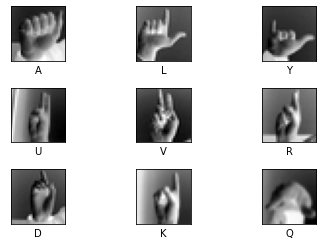

In [52]:
display_images(next_batch(9, x, y))

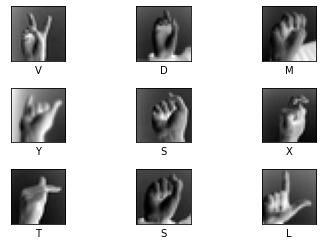

In [53]:
display_images(next_batch(10, x, y))

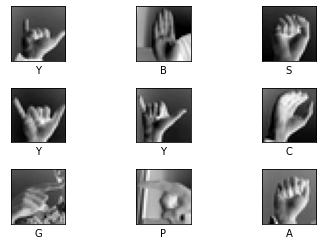

In [54]:
display_images(next_batch(1001, x, y))

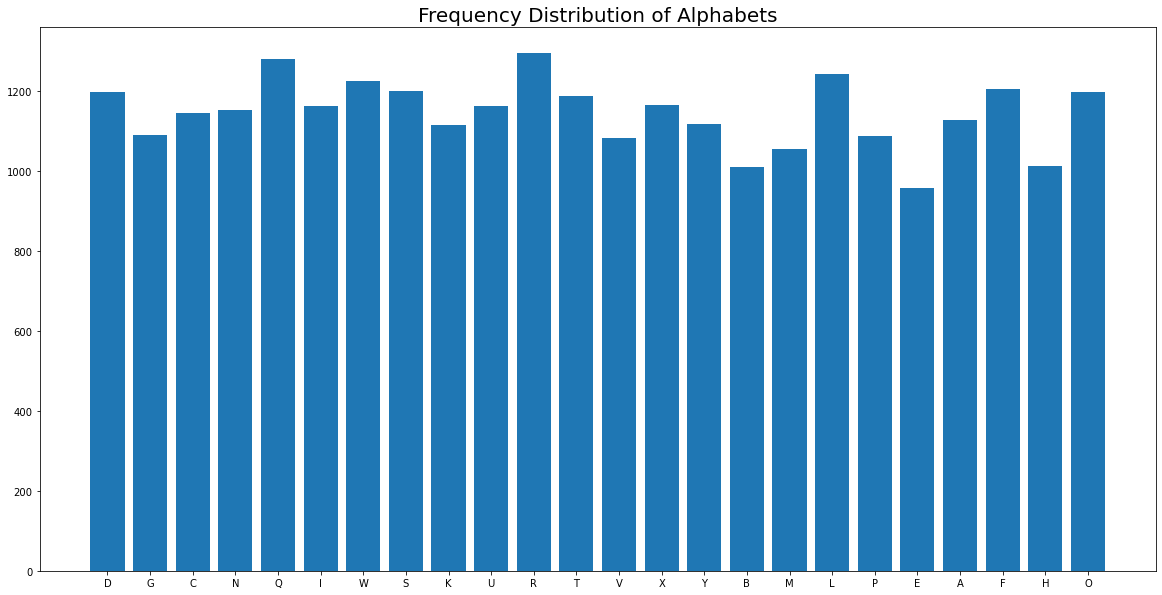

In [55]:
z = dict(Counter(list(y)))
labels = z.keys()
frequencies = [z[i] for i in labels]
labels = [chr(i + 65) for i in z.keys()]

plt.figure(figsize = (20, 10))
plt.bar(labels, frequencies)
plt.title('Frequency Distribution of Alphabets', fontsize = 20 ,
        )
plt.show()

In [56]:
def one_hot_encode(y):
    return np.eye(25)[y]
y_encoded = one_hot_encode(y)
print('Shape of y after encoding:', y_encoded.shape)

Shape of y after encoding: (27455, 25)


## Building the Convolutional Neural Network

In [57]:
# Training Parameters
learning_rate = 0.001
epochs = 2000
batch_size = 128
display_step = 100

In [58]:
# Neural Network Hyperparameters
n_input = 784
n_classes = 25
dropout = 0.75

In [59]:
import tensorflow.compat.v1 as tf ## to run attributes that tensorflow was not supporting in new version
tf.disable_v2_behavior()

In [60]:
# Placeholders
tf.disable_v2_behavior()
X = tf.placeholder(tf.float32, shape = [None, n_input]) # Placeholder for Feature Matrix
Y = tf.placeholder(tf.float32, shape = [None, n_classes]) # Placeholder for Labels
keep_prob = tf.placeholder(tf.float32) # Placeholder for Dropout Rate

In [61]:
weights = {
    # Weight for Convolutional Layer 1: 5x5 filter, 1 input channel, 32 output channels
    'w1' : tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # Weight for Convolutional Layer 2: 5x5 filter, 32 input channels, 64 output channels
    'w2' : tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # Weight for Fully Connected Layer 1: 49 * 64 input channels, 1024 output channels
    'w3' : tf.Variable(tf.random_normal([7 * 7 * 64, 1024])),
    # Weight for Convolutional Layer 1: 1024 input channels, 25(number of classes) output channels
    'w4' : tf.Variable(tf.random_normal([1024, n_classes]))
}

In [62]:
biases = {
    # Bias for Convolutional Layer 1
    'b1' : tf.Variable(tf.random_normal([32])),
    # Bias for Convolutional Layer 2
    'b2' : tf.Variable(tf.random_normal([64])),
    # Bias for Fully Connected Layer 1
    'b3' : tf.Variable(tf.random_normal([1024])),
    # Bias for Outout Layer
    'b4' : tf.Variable(tf.random_normal([n_classes]))
}

In [63]:
# Wrapper function for creating a Convolutional Layer
def conv2d(x, W, b, strides = 1):
    x = tf.nn.conv2d(x, W, strides = [1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [64]:
# Wrapper function for creating a Pooling Layer
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

In [65]:
def neural_network(x, weight, bias, dropout):
    x = tf.reshape(x, shape = [-1, 28, 28, 1])
    
    conv1 = conv2d(x, weight['w1'], bias['b1']) # Convolutional Layer 1
    conv1 = maxpool2d(conv1) # Pooling Layer 1
    
    conv2 = conv2d(conv1, weight['w2'], bias['b2']) # Convolutional Layer 1
    conv2 = maxpool2d(conv2) # Pooling Layer 1
    
    # Fully Connected Layer 1
    # Reshaping output of previous convolutional layer to fit the fully connected layer
    fc = tf.reshape(conv2, [-1, weights['w3'].get_shape().as_list()[0]])
    fc = tf.add(tf.matmul(fc, weight['w3']), bias['b3']) # Linear Function
    fc = tf.nn.relu(fc) # Activation Function
    
    fc = tf.nn.dropout(fc, dropout) # Applying dropout on Fully Connected Layer
    
    out = tf.add(tf.matmul(fc, weight['w4']), bias['b4']) # Output Layer
    return out

In [66]:
logits = neural_network(X, weights, biases, keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [67]:
loss_op = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = Y)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)

In [68]:
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [69]:
init = tf.global_variables_initializer()

## Training the Neural Network

In [70]:
# Splitting the dataset into Training and Holdout(Test set)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size = 0.33, random_state = 42)
print('X train shape', X_train.shape)
print('y train shape', y_train.shape)
print('X test shape', X_test.shape)
print('y test shape', y_test.shape)

X train shape (18394, 784)
y train shape (18394, 25)
X test shape (9061, 784)
y test shape (9061, 25)


In [71]:
with tf.Session() as sess:
    # Running Initializer
    sess.run(init)
    cost_hist, acc_hist = [], []
    for epoch in range(1, epochs + 1):
        _x, _y = next_batch(batch_size, X_train, y_train)
        # Running Optimizer
        sess.run(train_op, feed_dict = { X : _x, Y : _y, keep_prob : dropout })
        if epoch % display_step == 0:
            # Calculating Loss and Accuracy on the current Epoch
            loss, acc = sess.run([loss_op, accuracy], feed_dict = { X : _x, Y : _y, keep_prob : 1.0 })
            loss = sum(loss)
            cost_hist.append(loss)
            acc_hist.append(acc)
            print('Epoch ' + str(epoch) + ', Cost: ' + str(loss) + ', Accuracy: ' + str(acc * 100) + ' %')
    print('-' * 50)
    print('\nOptimization Finished\n')
    print('Accuracy on Training Data: ' + str(sess.run(accuracy,
                                                       feed_dict = {
                                                           X : X_train,
                                                           Y : y_train,
                                                           keep_prob : 1.0
                                                       }) * 100) + ' %')
    print('Accuracy on Test Data: ' + str(sess.run(accuracy,
                                                   feed_dict = {
                                                       X : X_test,
                                                       Y : y_test,
                                                       keep_prob : 1.0
                                                   }) * 100) + ' %')

Epoch 100, Cost: 115279733.25, Accuracy: 46.09375 %
Epoch 200, Cost: 22025938.75, Accuracy: 71.875 %
Epoch 300, Cost: 8370278.8125, Accuracy: 82.03125 %
Epoch 400, Cost: 9095270.3125, Accuracy: 82.03125 %
Epoch 500, Cost: 2331296.1875, Accuracy: 92.96875 %
Epoch 600, Cost: 1969855.875, Accuracy: 92.1875 %
Epoch 700, Cost: 1632421.5, Accuracy: 93.75 %
Epoch 800, Cost: 990971.4375, Accuracy: 95.3125 %
Epoch 900, Cost: 803081.40625, Accuracy: 96.09375 %
Epoch 1000, Cost: 206280.8125, Accuracy: 97.65625 %
Epoch 1100, Cost: 0.0, Accuracy: 100.0 %
Epoch 1200, Cost: 168478.1875, Accuracy: 98.4375 %
Epoch 1300, Cost: 123275.3125, Accuracy: 99.21875 %
Epoch 1400, Cost: 109394.78125, Accuracy: 99.21875 %
Epoch 1500, Cost: 87186.5, Accuracy: 99.21875 %
Epoch 1600, Cost: 0.0, Accuracy: 100.0 %
Epoch 1700, Cost: 16670.6875, Accuracy: 99.21875 %
Epoch 1800, Cost: 0.0, Accuracy: 100.0 %
Epoch 1900, Cost: 145652.0625, Accuracy: 99.21875 %
Epoch 2000, Cost: 0.0, Accuracy: 100.0 %
----------------------

In [ ]:
plt.plot(list(range(len(cost_hist))), cost_hist)
plt.title("Change in cost")
plt.show()

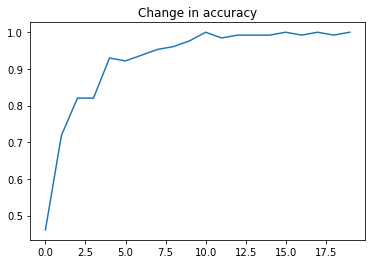

In [73]:
plt.plot(list(range(len(acc_hist))), acc_hist)
plt.title("Change in accuracy")
plt.show()

## Training the Neural Network on the whole dataset to get the Optimized Weights and Biases

In [74]:
print('Training on the whole dataset....\n')
with tf.Session() as sess:
    sess.run(init) # Running Initializer
    cost_hist, acc_hist = [], []
    for epoch in range(1, epochs + 1):
        _x, _y = next_batch(batch_size, x, y_encoded)
        # Running Optimizer
        sess.run(train_op,
                 feed_dict = {
                     X : _x,
                     Y : _y,
                     keep_prob : dropout
                 })
        if epoch % display_step == 0:
            # Calculating Loss and Accuracy on the current Epoch
            loss, acc = sess.run([loss_op, accuracy],
                                 feed_dict = {
                                     X : _x,
                                     Y : _y,
                                     keep_prob : 1.0
                                 })
            loss = sum(loss)
            cost_hist.append(loss)
            acc_hist.append(acc)
            print('Epoch ' + str(epoch) + ', Cost: ' + str(loss) + ', Accuracy: ' + str(acc * 100) + ' %')
    print('-' * 50)
    print('\nOptimization Finished\n')
    print('Accuracy after training on whole dataset Data: ' + str(sess.run(accuracy,
                                                       feed_dict = {
                                                           X : x,
                                                           Y : y_encoded,
                                                           keep_prob : 1.0
                                                       }) * 100) + ' %')
    W = sess.run(weights)
    B = sess.run(biases)

Training on the whole dataset....

Epoch 100, Cost: 215223022.625, Accuracy: 32.8125 %
Epoch 200, Cost: 57870045.375, Accuracy: 60.9375 %
Epoch 300, Cost: 19817892.125, Accuracy: 78.90625 %
Epoch 400, Cost: 7344756.1875, Accuracy: 84.375 %
Epoch 500, Cost: 6152375.6875, Accuracy: 87.5 %
Epoch 600, Cost: 2724744.5625, Accuracy: 89.84375 %
Epoch 700, Cost: 1001411.59375, Accuracy: 95.3125 %
Epoch 800, Cost: 281428.375, Accuracy: 96.09375 %
Epoch 900, Cost: 951034.9375, Accuracy: 96.09375 %
Epoch 1000, Cost: 321651.15625, Accuracy: 95.3125 %
Epoch 1100, Cost: 65324.9375, Accuracy: 99.21875 %
Epoch 1200, Cost: 238800.0, Accuracy: 97.65625 %
Epoch 1300, Cost: 26537.5625, Accuracy: 98.4375 %
Epoch 1400, Cost: 144332.0, Accuracy: 98.4375 %
Epoch 1500, Cost: 0.0, Accuracy: 100.0 %
Epoch 1600, Cost: 0.0, Accuracy: 100.0 %
Epoch 1700, Cost: 63809.0625, Accuracy: 99.21875 %
Epoch 1800, Cost: 55013.6875, Accuracy: 99.21875 %
Epoch 1900, Cost: 0.0, Accuracy: 100.0 %
Epoch 2000, Cost: 0.0, Accuracy:

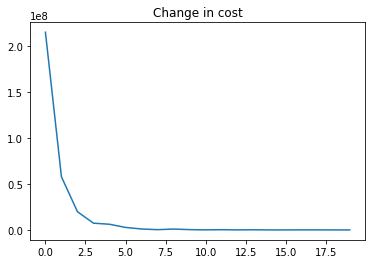

In [75]:
plt.plot(list(range(len(cost_hist))), cost_hist)
plt.title("Change in cost")
plt.show()

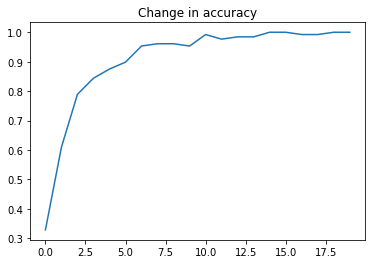

In [76]:
plt.plot(list(range(len(acc_hist))), acc_hist)
plt.title("Change in accuracy")
plt.show()